## Modul yang Dibutuhkan

In [41]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Membaca Data

In [5]:
data = pd.read_excel("fraud.xlsx")
data.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,2019-04-01 00:58:00,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11 00:00:00,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,2019-04-01 15:06:00,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11 00:00:00,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,2019-04-01 22:37:00,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11 00:00:00,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,2019-04-01 23:06:00,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11 00:00:00,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,2019-04-01 23:59:00,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11 00:00:00,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


## Preprocessing dan Exploratory Data Analysis (EDA) 

In [6]:
##Mengecek struktur dari data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

In [7]:
##Mengecek nilai kosong (missing value)
data.isnull().sum()

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
city                     0
state                    0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [8]:
##Mengecek statistik deskriptif 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
amt,14446.0,124.430073,231.352587,1.000000,12.080000,51.520000,101.030000,3.261470e+03
lat,14446.0,39.787692,5.317039,20.027100,36.715400,39.666200,41.940400,6.669330e+01
long,14446.0,-110.874225,12.985813,-165.672300,-120.415800,-111.098500,-101.136000,-8.962870e+01
city_pop,14446.0,106537.002838,290291.609056,46.000000,493.000000,1645.000000,35439.000000,2.383912e+06
merch_lat,14446.0,39.787991,5.360593,19.032689,36.794655,39.620953,42.275740,6.751027e+01
merch_long,14446.0,-110.874892,12.995596,-166.670685,-120.146253,-111.192629,-100.446822,-8.864637e+01


In [9]:
##mengecek label dari fraud
data['is_fraud'].unique()

array([1, '1"2020-12-24 16:56:24"', 0, '0"2019-01-01 00:00:44"'],
      dtype=object)

In [10]:
data[data['is_fraud'] == '1"2020-12-24 16:56:24"']

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
1781,2020-11-12 23:19:00,Thompson-Gleason,health_fitness,19.45,Lakeport,CA,39.047,-122.9328,11256,Podiatrist,18-10-1972,bfde75d978bb9905a4a8c87440692a4c,39.25188,-122.490946,"1""2020-12-24 16:56:24"""


In [11]:
data[data['is_fraud'] == '0"2019-01-01 00:00:44"']

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
7780,31-12-2020 23:59,Breitenberg LLC,travel,7.99,Mesa,ID,44.6255,-116.4493,129,Cartographer,15-12-1965,14392d723bb7737606b2700ac791b7aa,44.470525,-117.080888,"0""2019-01-01 00:00:44"""


In [12]:
##Memperbaiki label is_fraud
def clean_fraud_label(value):
    if isinstance(value, str):
        return int(value[0])  
    return value

data['is_fraud'] = data['is_fraud'].apply(clean_fraud_label)

In [13]:
data.iloc[1781]

trans_date_trans_time                 2020-11-12 23:19:00
merchant                                 Thompson-Gleason
category                                   health_fitness
amt                                                 19.45
city                                             Lakeport
state                                                  CA
lat                                                39.047
long                                            -122.9328
city_pop                                            11256
job                                            Podiatrist
dob                                            18-10-1972
trans_num                bfde75d978bb9905a4a8c87440692a4c
merch_lat                                        39.25188
merch_long                                    -122.490946
is_fraud                                                1
Name: 1781, dtype: object

In [14]:
data.iloc[7780]

trans_date_trans_time                    31-12-2020 23:59
merchant                                  Breitenberg LLC
category                                           travel
amt                                                  7.99
city                                                 Mesa
state                                                  ID
lat                                               44.6255
long                                            -116.4493
city_pop                                              129
job                                          Cartographer
dob                                            15-12-1965
trans_num                14392d723bb7737606b2700ac791b7aa
merch_lat                                       44.470525
merch_long                                    -117.080888
is_fraud                                                0
Name: 7780, dtype: object

In [15]:
data['is_fraud'].unique()

array([1, 0], dtype=int64)

In [16]:
##Menyamakan format datetime
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], errors='coerce', dayfirst=True)
data['dob'] = pd.to_datetime(data['dob'], errors='coerce', dayfirst=True)

In [17]:
##Menghitung usia dari pembeli
data['age_at_purchase'] = (data['trans_date_trans_time'].dt.year - data['dob'].dt.year) - \
    ((data['trans_date_trans_time'].dt.month < data['dob'].dt.month) | 
     ((data['trans_date_trans_time'].dt.month == data['dob'].dt.month) & 
      (data['trans_date_trans_time'].dt.day < data['dob'].dt.day))).astype(int)

In [18]:
##Menghitung jarak antara lokasi pedagang dan lokasi pembelian
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  

data['distance_to_merchant'] = data.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

In [19]:
data.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,age_at_purchase,distance_to_merchant
0,2019-04-01 00:58:00,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1,79,109.285552
1,2019-04-01 15:06:00,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1,79,79.856896
2,2019-04-01 22:37:00,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1,79,66.807915
3,2019-04-01 23:06:00,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1,79,39.636227
4,2019-04-01 23:59:00,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",1939-09-11,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1,79,77.611529


In [20]:
data['merchant'].nunique()

693

In [21]:
data['category'].nunique()

14

In [22]:
data['city'].nunique()

176

In [23]:
data['state'].nunique()

13

In [24]:
data['job'].nunique()

163

In [25]:
##Menghapus kolom
data = data.drop(columns=['trans_date_trans_time', 'lat', 'long', 'dob', 'trans_num', 'merch_lat', 'merch_long'])

In [26]:
data.head()

,merchant,category,amt,city,state,city_pop,job,is_fraud,age_at_purchase,distance_to_merchant
0,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,145,"""Administrator, education""",1,79,109.285552
1,Predovic Inc,shopping_net,966.11,Wales,AK,145,"""Administrator, education""",1,79,79.856896
2,Wisozk and Sons,misc_pos,49.61,Wales,AK,145,"""Administrator, education""",1,79,66.807915
3,Murray-Smitham,grocery_pos,295.26,Wales,AK,145,"""Administrator, education""",1,79,39.636227
4,Friesen Lt,health_fitness,18.17,Wales,AK,145,"""Administrator, education""",1,79,77.611529


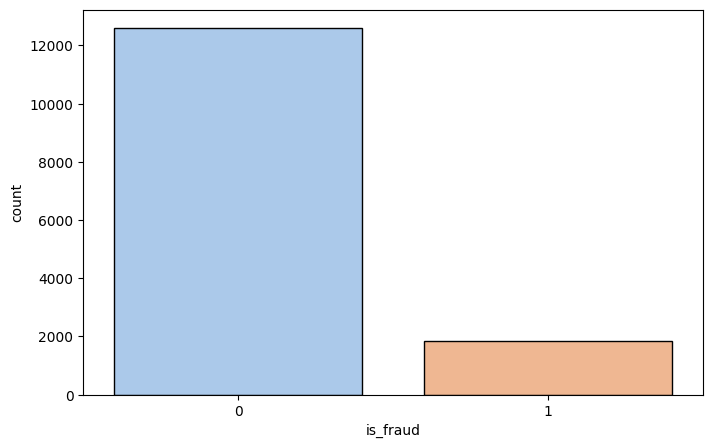

is_fraud
0    12601
1     1845
Name: count, dtype: int64

In [27]:
##Mengecek data dari kolom is_fraud (target) 
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='is_fraud', palette='pastel', edgecolor="black")
plt.grid(False)
plt.show()

data['is_fraud'].value_counts()

In [28]:
##Menentukkan kolom dengan tipe faktor (category) dan numerik
str_list = [] 
num_list = []
for colname, colvalue in data.items():
    if colname == 'is_fraud':  
        continue  
    if type(colvalue[1]) == str:
        str_list.append(colname)
    else:
        num_list.append(colname)

        
str_list

['merchant', 'category', 'city', 'state', 'job']

In [29]:
num_list

['amt', 'city_pop', 'age_at_purchase', 'distance_to_merchant']

In [30]:
# Membuat objek OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  
encoded_features = encoder.fit_transform(data[str_list])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(str_list))

data = data.drop(columns=str_list)  
data = pd.concat([data, encoded_df], axis=1)  


##Melakukan label encoding
for col in str_list:
    encoder = LabelEncoder()
    encoder.fit(data[col])
    data[col] = encoder.transform(data[col])

In [31]:
##Melakukan standarisasi data
for col in num_list:
    scaler = StandardScaler()
    data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1)).flatten()

In [32]:
##Splitting data
X = data.drop(columns=['is_fraud'])  
y = data['is_fraud'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [33]:
##Mengatasi imbalance data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [34]:
y_train_resampled.value_counts()

is_fraud
0    8821
1    8821
Name: count, dtype: int64

## Melakukan Klasifikasi
### XGBoost

In [35]:
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=10000, learning_rate=0.3,
                            n_jobs=-1)

In [36]:
xgb_clf.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
y_pred_xgb = xgb_clf.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3780
           1       0.91      0.90      0.90       554

    accuracy                           0.98      4334
   macro avg       0.95      0.94      0.94      4334
weighted avg       0.97      0.98      0.98      4334



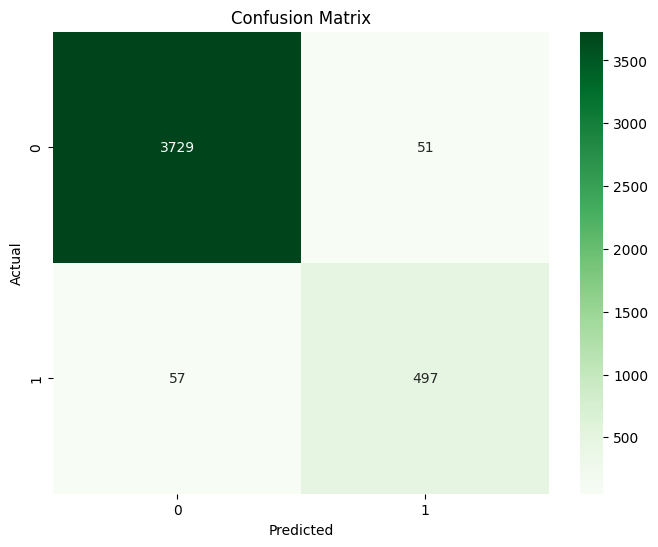

In [42]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Hyperparamter Tuning dari XGBoost

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Mendefinisikan rentang parameter
space = {
    'max_depth': hp.quniform("max_depth", 3, 15, 1),  # Mengurangi rentang untuk lebih terfokus
    'gamma': hp.uniform('gamma', 0, 5),  # Mengurangi rentang untuk gamma
    'reg_alpha': hp.quniform('reg_alpha', 0, 200, 1),  # Rentang untuk reg_alpha
    'reg_lambda': hp.uniform('reg_lambda', 0, 2),  # Rentang untuk reg_lambda
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),  # Memastikan nilai minimum adalah 1
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),  # Rentang yang benar untuk n_estimators
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # Tuning untuk learning rate
    'n_jobs': hp.choice('n_jobs', [1, 2, 4, 8, -1]),  # Menggunakan -1 untuk semua core
    'seed': 0
}

def objective(space):
    # Membuat model XGBoost dengan hyperparameter yang diberikan
    xgb_clf = xgb.XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        reg_lambda=space['reg_lambda'],
        learning_rate=space['learning_rate'],
        n_jobs=space['n_jobs'],
        seed=space['seed']
    )
    
    # Evaluasi model
    evaluation = [(X_train_resampled, y_train_resampled), (X_test, y_test)]
    
    xgb_clf.fit(X_train_resampled, y_train_resampled,
                 eval_set=evaluation, eval_metric="auc",
                 early_stopping_rounds=10, verbose=False)
    
    # Prediksi dan hitung akurasi
    pred = xgb_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print("SCORE:", accuracy)
    
    # Mengembalikan nilai loss dan akurasi untuk analisis
    return {'loss': 1 - accuracy, 'status': STATUS_OK, 'accuracy': accuracy}

# Menyimpan hasil percobaan
trials = Trials()

# Melakukan optimasi hyperparameter
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print("Best Hyperparameters:", best_hyperparams)


SCORE:                                                 
0.14878892733564014                                    
SCORE:                                                                           
0.127681660899654                                                                
SCORE:                                                                           
0.23252595155709344                                                              
SCORE:                                                                           
0.13910034602076124                                                              
SCORE:                                                                           
0.23356401384083045                                                              
SCORE:                                                                           
0.12802768166089964                                                              
SCORE:                                                              